In [1]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"irfanhayat361","key":"d850d19644fde8b8fae42427403e3819"}'}

In [4]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

# Unzip
import zipfile
with zipfile.ZipFile("/content/microsoft-catsvsdogs-dataset.zip","r") as zip_ref:
    zip_ref.extractall("/content/")

Dataset URL: https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset
License(s): other
microsoft-catsvsdogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import os

base_dir = "/content/kaggle/Cats-vs-Dogs"
train_dir = os.path.join(base_dir, "Train")
test_dir  = os.path.join(base_dir, "Test")

# Create dirs
os.makedirs(train_dir + "/Cats", exist_ok=True)
os.makedirs(train_dir + "/Dogs", exist_ok=True)
os.makedirs(test_dir + "/Cats", exist_ok=True)
os.makedirs(test_dir + "/Dogs", exist_ok=True)

# Source dirs from dataset
cat_source = "/content/PetImages/Cat/"
dog_source = "/content/PetImages/Dog/"


In [8]:
import random, shutil
from PIL import Image

def clean_and_split(SOURCE, TRAINING, TESTING, SPLIT_SIZE, prefix):
    files = []
    for fname in os.listdir(SOURCE):
        path = os.path.join(SOURCE, fname)
        try:
            if os.path.getsize(path) > 0:
                img = Image.open(path)   # try opening
                img.verify()
                files.append(fname)
        except:
            continue  # skip corrupted

    random.shuffle(files)
    train_size = int(len(files) * SPLIT_SIZE)
    train_data = files[:train_size]
    test_data  = files[train_size:]

    for fname in train_data:
        shutil.copy(os.path.join(SOURCE, fname), os.path.join(TRAINING, prefix + "-" + fname))
    for fname in test_data:
        shutil.copy(os.path.join(SOURCE, fname), os.path.join(TESTING, prefix + "-" + fname))

# Run splitting
clean_and_split(cat_source, train_dir+"/Cats", test_dir+"/Cats", 0.8, "cat")
clean_and_split(dog_source, train_dir+"/Dogs", test_dir+"/Dogs", 0.8, "dog")

print("Train Cats:", len(os.listdir(train_dir+"/Cats")))
print("Train Dogs:", len(os.listdir(train_dir+"/Dogs")))
print("Test Cats:", len(os.listdir(test_dir+"/Cats")))
print("Test Dogs:", len(os.listdir(test_dir+"/Dogs")))


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Train Cats: 9999
Train Dogs: 9999
Test Cats: 2500
Test Dogs: 2500


In [9]:
from tensorflow import keras

# Train generator (with augmentation)
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Test generator (only rescale)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)


Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [10]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,076,673 (225.36 MB)

 Trainable params: 59,076,673 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(
    train_set,
    validation_data=test_set,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
309/625 ━━━━━━━━━━━━━━━━━━━━ 27:32 5s/step - accuracy: 0.5516 - loss: 0.7071

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 3436s 5s/step - accuracy: 0.5903 - loss: 0.6725 - val_accuracy: 0.7450 - val_loss: 0.5078
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3412s 5s/step - accuracy: 0.7334 - loss: 0.5337 - val_accuracy: 0.7568 - val_loss: 0.5228
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3325s 5s/step - accuracy: 0.7813 - loss: 0.4661 - val_accuracy: 0.7968 - val_loss: 0.4390
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3315s 5s/step - accuracy: 0.8021 - loss: 0.4327 - val_accuracy: 0.7880 - val_loss: 0.4426
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3329s 5s/step - accuracy: 0.8203 - loss: 0.4056 - val_accuracy: 0.8214 - val_loss: 0.3874
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3332s 5s/step - accuracy: 0.8274 - loss: 0.3886 - val_accuracy: 0.8282 - val_loss: 0.3741
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3367s 5s/step - accuracy: 0.8374 - loss: 0.3666 - val_accuracy: 0.8580 - val_loss: 0.3370
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3400s 5s/step - accuracy: 0.8517 - loss: 0.3443 - val_accurac

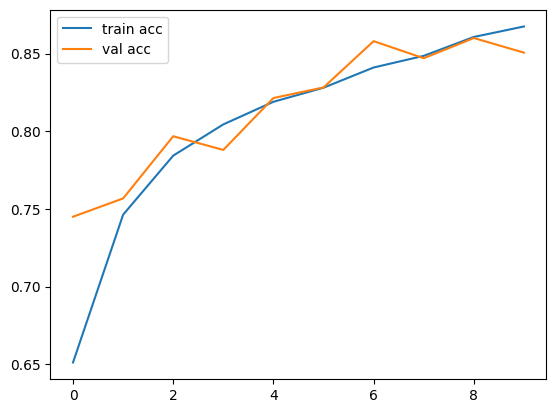

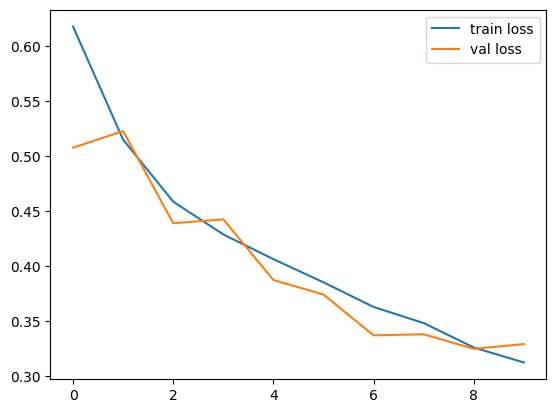

In [12]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predict labels
Y_pred = model.predict(test_set)
y_pred = np.round(Y_pred).astype(int).reshape(-1)

print(confusion_matrix(test_set.classes, y_pred))
print(classification_report(test_set.classes, y_pred, target_names=["Cats","Dogs"]))


157/157 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step
[[1102 1398]
 [1093 1407]]
              precision    recall  f1-score   support

        Cats       0.50      0.44      0.47      2500
        Dogs       0.50      0.56      0.53      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



In [14]:
model.save("/content/cats_vs_dogs_model_final.h5")
print("Saved /content/cats_vs_dogs_model_final.h5")

Saved /content/cats_vs_dogs_model_final.h5


**Evaluate final loss & accuracy on the test set**

In [15]:
loss, accuracy = model.evaluate(test_set, verbose=1)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8538 - loss: 0.3231
Test loss: 0.3291
Test accuracy: 0.8506


**Get predictions and compute confusion matrix + classification report**

In [16]:
# 2) Predictions -> confusion matrix & classification report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Ensure test_set.shuffle == False so ordering aligns
# test_set.shuffle = False  # if needed before re-creating the generator

# Predict probabilities for all test samples
preds = model.predict(test_set, verbose=1)               # shape (N,1)
y_pred = (preds > 0.5).astype(int).reshape(-1)            # binary predictions 0/1
y_true = test_set.classes                                 # ground-truth labels

# Ensure lengths match (sometimes last batch padding)
N = min(len(y_true), len(y_pred))
y_true = y_true[:N]
y_pred = y_pred[:N]

# Confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=predicted):")
print(cm)

# Map class indices -> names to show labels in the report
class_names = list(train_set.class_indices.keys())  # e.g. ['Cats','Dogs']
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names))


157/157 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step
Confusion matrix (rows=true, cols=predicted):
[[1093 1407]
 [1102 1398]]

Classification report:
              precision    recall  f1-score   support

        Cats       0.50      0.44      0.47      2500
        Dogs       0.50      0.56      0.53      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



**Visualize confusion matrix (simple heatmap with matplotlib)**

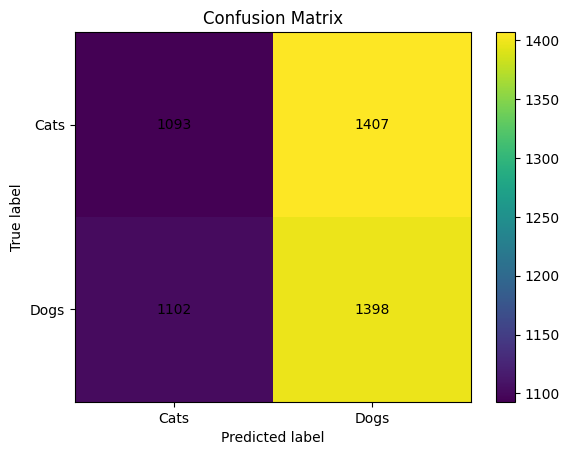

In [17]:
# 3) Plot confusion matrix (matplotlib only)
import matplotlib.pyplot as plt
import numpy as np

cm_arr = np.array(cm)
plt.figure()
plt.imshow(cm_arr, interpolation='nearest', aspect='auto')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(ticks=[0,1], labels=class_names)
plt.yticks(ticks=[0,1], labels=class_names)

# annotate counts
thresh = cm_arr.max() / 2.
for i in range(cm_arr.shape[0]):
    for j in range(cm_arr.shape[1]):
        plt.text(j, i, format(cm_arr[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center")
plt.colorbar()
plt.show()


**Plot training curves (accuracy & loss)**

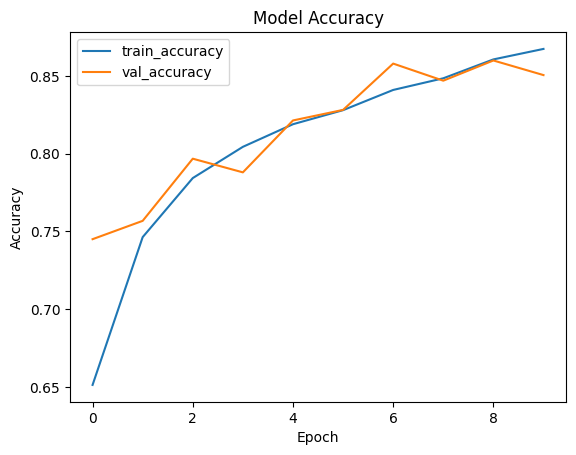

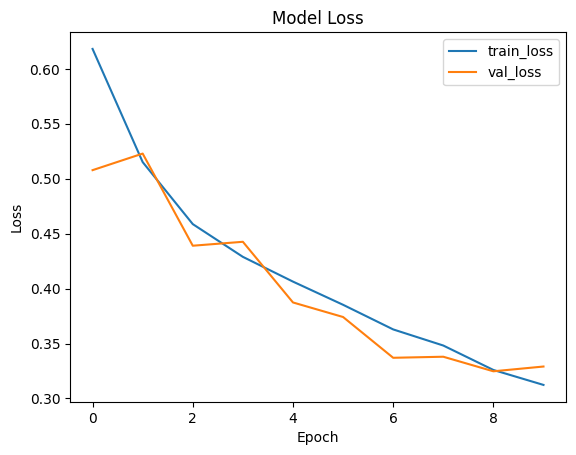

In [18]:
# 4) Plot training and validation accuracy & loss using `history` returned by model.fit
# Make sure `history` variable exists (the return value from model.fit). If you trained in a different session,
# try loading the history object if saved, or retrain quickly.

plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


**Useful extra metrics (per-class recall/precision)**

In [19]:
# 5) Compute per-class precision & recall explicitly (optional)
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

for i, cname in enumerate(class_names):
    print(f"{cname} -- Precision: {precision[i]:.3f}, Recall: {recall[i]:.3f}, F1: {f1[i]:.3f}")


Cats -- Precision: 0.498, Recall: 0.437, F1: 0.466
Dogs -- Precision: 0.498, Recall: 0.559, F1: 0.527


**Q1: What is the advantage of Convolutional Layers over Fully Connected Layers?**
Convolutional layers have a big advantage because they need far fewer parameters compared to fully connected layers. In a fully connected layer, each neuron is linked to every input pixel, which makes the network very large and heavy to compute, especially for images. Convolutional layers, however, only look at small regions of the image at a time, and the same filters are used across the whole image. This makes them more efficient and faster. Another important benefit is that convolutional layers keep the spatial structure of the image intact and can learn patterns like edges, shapes, or textures no matter where they appear. For this reason, convolutional layers are ideal for images, while fully connected layers are generally used towards the end for the final classification.

Q2: What is the role of Pooling Layers in reducing the complexity of a CNN?
Pooling layers help by shrinking the size of the feature maps, which lowers the amount of computation needed in later layers. By reducing the dimensions, they also make the model less likely to overfit. Pooling ensures that the network becomes less sensitive to small shifts or distortions in the image, since it focuses more on whether a feature is present rather than where exactly it is. In simple terms, pooling layers reduce the workload, improve efficiency, and make the CNN more reliable when handling real-world images.

Q3: Comparison of Pooling Layers
Pooling can be done in different ways, but the two most common types are max pooling and average pooling. To understand the difference, let’s take a 4×4 input matrix and apply a 2×2 pooling window.

Input:

    1   2   3   4

    5   6   7   8

    9  10  11  12

    13 14  15  16


With max pooling, we take the largest value from each 2×2 block, which gives:

    6   8

    14 16


With average pooling, we take the mean of each block, which results in:

    3.5   5.5
    11.5 13.5


So, max pooling highlights the strongest features in the region, while average pooling smooths the data and keeps a general sense of the information.